In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q nltk
!pip install -q tensorflow

In [ ]:
import pandas as pd
import re
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

In [ ]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/data/train.csv', header=None, names=['label', 'title', 'description'])
test = pd.read_csv('/content/drive/MyDrive/data/train.csv', header=None, names=['label', 'title', 'description'])

In [ ]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        201 non-null    object
 1   title        201 non-null    object
 2   description  201 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB


,label,title,description
count,201,201,201
unique,5,201,5
top,1,title,Breaking international story about geopolitics.
freq,50,1,50


In [ ]:
test.info()
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        201 non-null    object
 1   title        201 non-null    object
 2   description  201 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB


,label,title,description
count,201,201,201
unique,5,201,5
top,1,title,Breaking international story about geopolitics.
freq,50,1,50


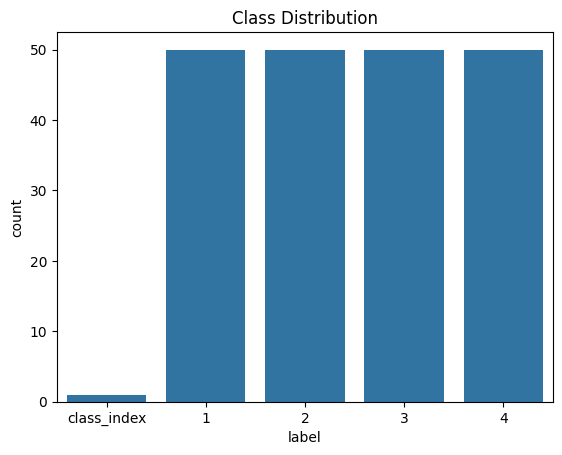

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='label', data=train)
plt.title("Class Distribution")
plt.show()

In [ ]:
for i in train['label'].unique():
    print(f"Class {i} sample titles:")
    print(train[train['label'] == i]['title'].head(3))
    print("\n")

Class class_index sample titles:
0    title
Name: title, dtype: object


Class 1 sample titles:
1    World News #0
5    World News #4
9    World News #8
Name: title, dtype: object


Class 2 sample titles:
2     Business update #1
6     Business update #5
10    Business update #9
Name: title, dtype: object


Class 3 sample titles:
3      Sports highlight #2
7      Sports highlight #6
11    Sports highlight #10
Name: title, dtype: object


Class 4 sample titles:
4      Tech release #3
8      Tech release #7
12    Tech release #11
Name: title, dtype: object




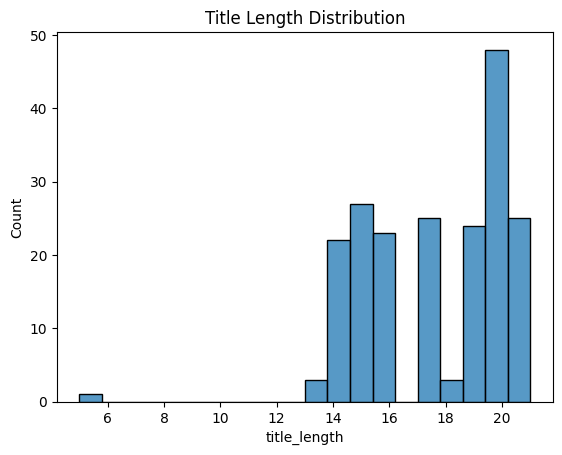

In [ ]:
train['title_length'] = train['title'].apply(len)
sns.histplot(train['title_length'], bins=20)
plt.title("Title Length Distribution")
plt.show()

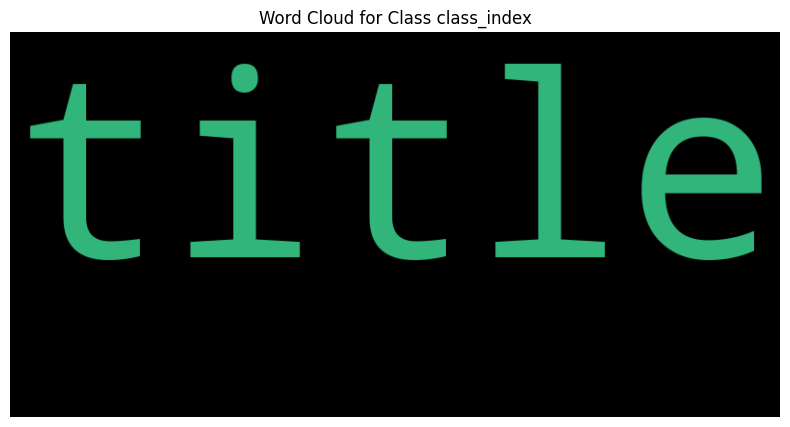

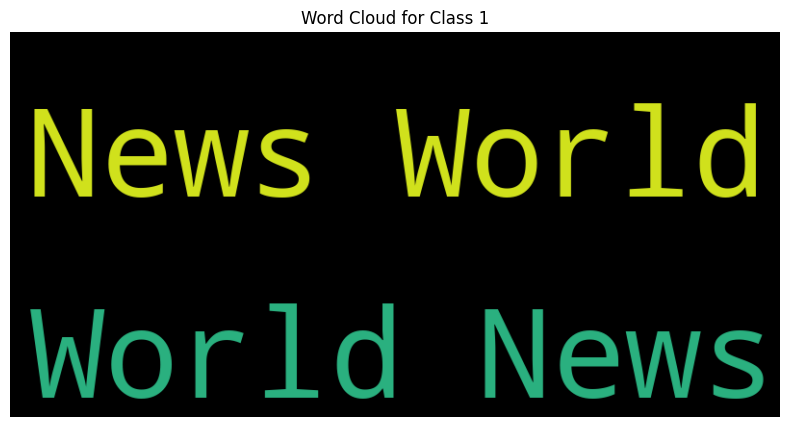

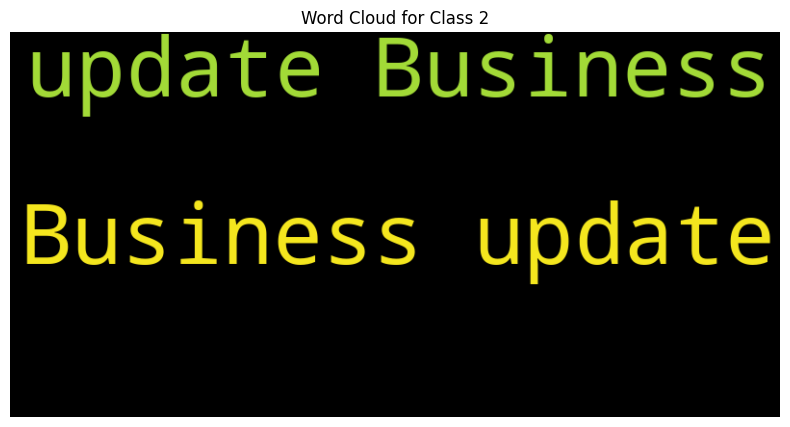

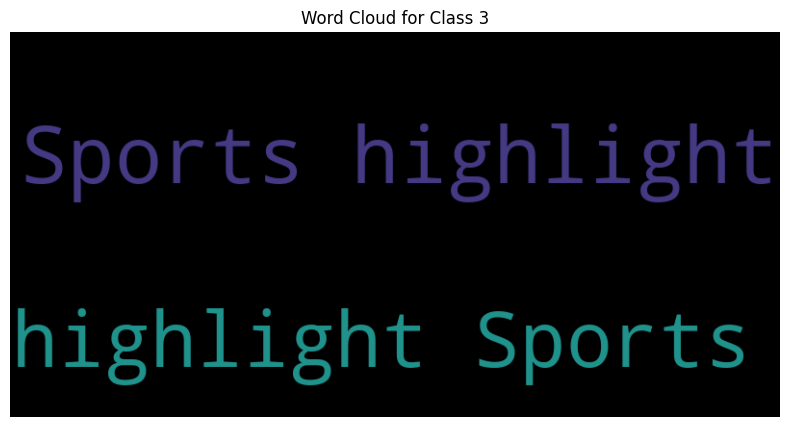

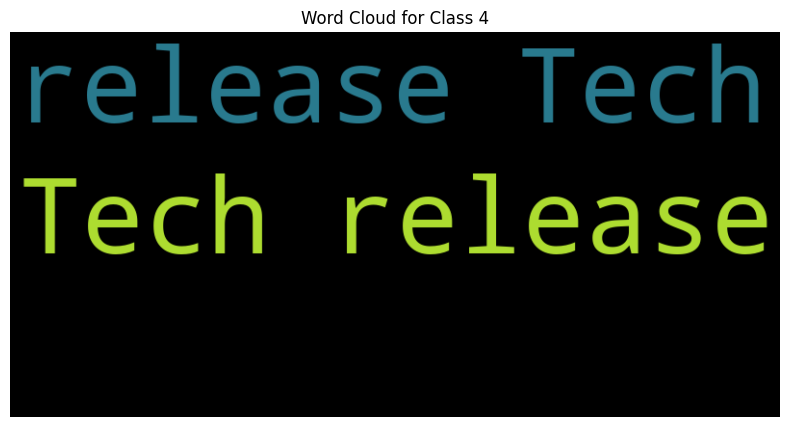

In [ ]:
from wordcloud import WordCloud

for i in train['label'].unique():
    text = " ".join(train[train['label']==i]['title'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Class {i}")
    plt.show()


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = [word for word in text.split() if word not in stop_words]
    return " ".join(words)

train['text'] = (train['title'] + " " + train['description']).apply(clean_text)
test['text'] = (test['title'] + " " + test['description']).apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_train = le.fit_transform(train['label'])
y_test = le.transform(test['label'])

num_classes = len(np.unique(y_train))

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)


In [ ]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
print(list(encoder.classes_))

[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [ ]:
label_map = {i: original for i, original in enumerate(encoder.classes_)}
print(label_map)


{0: np.int64(0), 1: np.int64(1), 2: np.int64(2), 3: np.int64(3), 4: np.int64(4)}


In [ ]:
import joblib
joblib.dump(le, "ml_label_encoder.pkl")

['ml_label_encoder.pkl']

In [ ]:
print("Unique labels after LabelEncoder:", np.unique(y_train))
print("Max label:", np.max(y_train))

Unique labels after LabelEncoder: [0 1 2 3 4]
Max label: 4


In [ ]:
def train_and_evaluate(model_name, model, vectorizer, X_train_text, X_test_text, y_train, y_test):
    X_train_vec = vectorizer.fit_transform(X_train_text)
    X_test_vec = vectorizer.transform(X_test_text)

    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{model_name} | {type(vectorizer).__name__}")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    return {
        "Model": model_name,
        "Vectorizer": type(vectorizer).__name__,
        "Accuracy": acc,
        "F1 Score": f1
    }


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer(max_features=5000)
tfidf = TfidfVectorizer(max_features=5000)
vectorizers = [cv, tfidf]
best_model = None
best_vectorizer = None
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}
results = []
for name, model in models.items():
    for vect in vectorizers:
        result = train_and_evaluate(name, model, vect, train['text'], test['text'], y_train, y_test)
        results.append(result)

        if name == "Logistic Regression" and isinstance(vect, TfidfVectorizer):
            best_model = model
            best_vectorizer = vect


Logistic Regression | CountVectorizer
Accuracy: 1.0
F1 Score: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        50
 class_index       1.00      1.00      1.00         1

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Logistic Regression | TfidfVectorizer
Accuracy: 0.9950248756218906
F1 Score: 0.9925619427614404
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50
           3       0.98      1.00      0.99        50
           4       1.00      1.00      1.00        50
 class_index       0.00      0.00      0.00         1

    accuracy           

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Random Forest | CountVectorizer
Accuracy: 1.0
F1 Score: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        50
 class_index       1.00      1.00      1.00         1

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Random Forest | TfidfVectorizer
Accuracy: 1.0
F1 Score: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        50
 class_index       1.00      1.00      1.00         1

    accuracy                           1.00       201
   macro av

In [ ]:
results_df = pd.DataFrame(results)
print("\n Final Comparison Table:")
print(results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True))


 Final Comparison Table:
                 Model       Vectorizer  Accuracy  F1 Score
0  Logistic Regression  CountVectorizer  1.000000  1.000000
1          Naive Bayes  CountVectorizer  1.000000  1.000000
2        Random Forest  TfidfVectorizer  1.000000  1.000000
3        Random Forest  CountVectorizer  1.000000  1.000000
4  Logistic Regression  TfidfVectorizer  0.995025  0.992562
5          Naive Bayes  TfidfVectorizer  0.995025  0.992562


In [ ]:
import joblib

joblib.dump(best_model, 'logistic_regression_model.pkl')
joblib.dump(best_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [ ]:
import joblib
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
joblib.dump(le, "dl_label_encoder.pkl")

['dl_label_encoder.pkl']

In [ ]:
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train['text'])

# Vectorizer 1: Regular padded sequence
X_train_pad1 = pad_sequences(tokenizer.texts_to_sequences(train['text']), maxlen=100, padding='post')
X_test_pad1 = pad_sequences(tokenizer.texts_to_sequences(test['text']), maxlen=100, padding='post')

# Vectorizer 2: Truncated shorter sequence
X_train_pad2 = pad_sequences(tokenizer.texts_to_sequences(train['text']), maxlen=50, padding='post')
X_test_pad2 = pad_sequences(tokenizer.texts_to_sequences(test['text']), maxlen=50, padding='post')


In [ ]:
def train_dl_model(name, model_fn, X_train, X_test, y_train_cat, y_test_cat, y_test, max_len):
    model = model_fn(vocab_size, max_len)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train_cat, epochs=5, batch_size=128, validation_split=0.1, verbose=1)

    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n {name} Results")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    return {
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1
    }, model


In [ ]:
def create_lstm_model(vocab_size, max_len):
    model = Sequential([
        Embedding(vocab_size, 64, input_length=max_len),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_gru_model(vocab_size, max_len):
    model = Sequential([
        Embedding(vocab_size, 64, input_length=max_len),
        GRU(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
dl_results = []

# LSTM with full padding
dl_results.append(train_dl_model("LSTM + Pad(100)", create_lstm_model, X_train_pad1, X_test_pad1, y_train_cat, y_test_cat, y_test, 100))

# LSTM with shorter padding
dl_results.append(train_dl_model("LSTM + Pad(50)", create_lstm_model, X_train_pad2, X_test_pad2, y_train_cat, y_test_cat, y_test, 50))

# GRU with full padding
dl_results.append(train_dl_model("GRU + Pad(100)", create_gru_model, X_train_pad1, X_test_pad1, y_train_cat, y_test_cat, y_test, 100))

# GRU with shorter padding
dl_results.append(train_dl_model("GRU + Pad(50)", create_gru_model, X_train_pad2, X_test_pad2, y_train_cat, y_test_cat, y_test, 50))


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 614ms/step - accuracy: 0.2678 - loss: 1.6023 - val_accuracy: 0.2381 - val_loss: 1.5827
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.2463 - loss: 1.5824 - val_accuracy: 0.2381 - val_loss: 1.5581
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2233 - loss: 1.5561 - val_accuracy: 0.2381 - val_loss: 1.5274
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2411 - loss: 1.5276 - val_accuracy: 0.2381 - val_loss: 1.4933
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.2552 - loss: 1.4918 - val_accuracy: 0.2381 - val_loss: 1.4618
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

 LSTM + Pad(100) Results
Accuracy: 0.24875621890547264
F1 Score: 0.09910606330895325
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.25      1.00      0.40        50
           4       0.00      0.00      0.00 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.1532 - loss: 1.6093 - val_accuracy: 0.2857 - val_loss: 1.5865
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step - accuracy: 0.3005 - loss: 1.5868 - val_accuracy: 0.2381 - val_loss: 1.5652
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 767ms/step - accuracy: 0.2704 - loss: 1.5671 - val_accuracy: 0.2381 - val_loss: 1.5395
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step - accuracy: 0.2574 - loss: 1.5416 - val_accuracy: 0.2381 - val_loss: 1.5082
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step - accuracy: 0.2526 - loss: 1.5122 - val_accuracy: 0.2381 - val_loss: 1.4737
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step

 LSTM + Pad(50) Results
Accuracy: 0.24875621890547264
F1 Score: 0.09910606330895325
              precision    recall  f1-score   support

           1       0.25      1.00      0.40        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - accuracy: 0.2837 - loss: 1.6038 - val_accuracy: 0.2381 - val_loss: 1.5927
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2541 - loss: 1.5914 - val_accuracy: 0.2381 - val_loss: 1.5806
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.2500 - loss: 1.5805 - val_accuracy: 0.2381 - val_loss: 1.5690
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.2474 - loss: 1.5705 - val_accuracy: 0.2381 - val_loss: 1.5573
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2578 - loss: 1.5597 - val_accuracy: 0.2381 - val_loss: 1.5458


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

 GRU + Pad(100) Results
Accuracy: 0.24875621890547264
F1 Score: 0.09910606330895325
              precision    recall  f1-score   support

           1       0.25      1.00      0.40        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50
 class_index       0.00      0.00      0.00         1

    accuracy                           0.25       201
   macro avg       0.05      0.20      0.08       201
weighted avg       0.06      0.25      0.10       201

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 674ms/step - accuracy: 0.1836 - loss: 1.6064 - val_accuracy: 0.2381 - val_loss: 1.5808
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.2678 - loss: 1.5797 - val_accuracy: 0.2381 - val_loss: 1.5607
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2656 - loss: 1.5585 - val_accuracy: 0.2381 - val_loss: 1.5389
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2548 - loss: 1.5436 - val_accuracy: 0.2381 - val_loss: 1.5171
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.2537 - loss: 1.5292 - val_accuracy: 0.2381 - val_loss: 1.4958


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

 GRU + Pad(50) Results
Accuracy: 0.24875621890547264
F1 Score: 0.09910606330895325
              precision    recall  f1-score   support

           1       0.25      1.00      0.40        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50
 class_index       0.00      0.00      0.00         1

    accuracy                           0.25       201
   macro avg       0.05      0.20      0.08       201
weighted avg       0.06      0.25      0.10       201



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
metrics_only = [item[0] if isinstance(item, tuple) else item for item in dl_results]

# Create DataFrame from just the metrics
dl_df = pd.DataFrame(metrics_only)

print("\nDeep Learning Model Comparison:")
print(dl_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True))


Deep Learning Model Comparison:
             Model  Accuracy  F1 Score
0  LSTM + Pad(100)  0.248756  0.099106
1   LSTM + Pad(50)  0.248756  0.099106
2   GRU + Pad(100)  0.248756  0.099106
3    GRU + Pad(50)  0.248756  0.099106


In [ ]:
gru_pad50_result, gru_pad50_model = train_dl_model(
    "GRU + Pad(50)",
    create_gru_model,
    X_train_pad1,
    X_test_pad1,
    y_train_cat,
    y_test_cat,
    y_test,
    50
)



Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 951ms/step - accuracy: 0.2552 - loss: 1.6042 - val_accuracy: 0.2857 - val_loss: 1.5888
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.2515 - loss: 1.5883 - val_accuracy: 0.2857 - val_loss: 1.5745
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.2437 - loss: 1.5792 - val_accuracy: 0.2857 - val_loss: 1.5591
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.2463 - loss: 1.5655 - val_accuracy: 0.2857 - val_loss: 1.5426
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.2437 - loss: 1.5492 - val_accuracy: 0.2857 - val_loss: 1.5262
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

 GRU + Pad(50) Results
Accuracy: 0.24875621890547264
F1 Score: 0.09910606330895325
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.25      1.00      0.40   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from google.colab import files
import joblib

# Save the GRU model
gru_pad50_model.save("gru_pad50_model.h5")

# Save the tokenizer
joblib.dump(tokenizer, "gru_pad50_tokenizer.pkl")

# Download both if you're on Colab
from google.colab import files
files.download("gru_pad50_model.h5")
files.download("gru_pad50_tokenizer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip uninstall -y transformers

Found existing installation: transformers 4.55.4
Uninstalling transformers-4.55.4:
  Successfully uninstalled transformers-4.55.4


In [ ]:
!pip install transformers==4.44.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 41.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.4
    Uninstalling tokenizers-0.21.4:
      Successfully uninstalled tokenizers-0.21.4


In [ ]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/data/train.csv', header=None, names=['label', 'title', 'description'])
test = pd.read_csv('/content/drive/MyDrive/data/test.csv', header=None, names=['label', 'title', 'description'])


In [ ]:
print(train.columns)

Index(['label', 'title', 'description'], dtype='object')


In [ ]:
train['text'] = train['title'].astype(str) + " " + train['description'].astype(str)
test['text'] = test['title'].astype(str) + " " + test['description'].astype(str)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create label encoder
label_encoder = LabelEncoder()

# Fit on training labels and transform both train and test
train['label'] = label_encoder.fit_transform(train['label'])
test['label'] = label_encoder.transform(test['label'])

# Now recreate Hugging Face datasets
from datasets import Dataset
train_ds = Dataset.from_pandas(train[['text', 'label']])
test_ds = Dataset.from_pandas(test[['text', 'label']])


In [ ]:
joblib.dump(label_encoder, "transformer_label_encoder.pkl")

['transformer_label_encoder.pkl']

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer_max = AutoTokenizer.from_pretrained(checkpoint)
tokenizer_long = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Tokenizer 1: max_length
def tokenize_max(examples):
    return tokenizer_max(examples['text'], padding="max_length", truncation=True)

# Tokenizer 2: longest
def tokenize_longest(examples):
    return tokenizer_long(examples['text'], padding="longest", truncation=True)

# Apply both
train_max = train_ds.map(tokenize_max, batched=True)
test_max = test_ds.map(tokenize_max, batched=True)

train_long = train_ds.map(tokenize_longest, batched=True)
test_long = test_ds.map(tokenize_longest, batched=True)

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

# Patch torch.load so HF ignores weights_only=True
orig_torch_load = torch.load
def torch_load_with_full_unpickling(*args, **kwargs):
    kwargs["weights_only"] = False
    return orig_torch_load(*args, **kwargs)
torch.load = torch_load_with_full_unpickling


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import os
import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='weighted')
    }

def train_transformer_model(model_name, tokenized_train, tokenized_test, tokenizer, output_dir, save_steps=500):
    # Check for checkpoint
    last_checkpoint = None
    if os.path.isdir(output_dir):
        checkpoints = [os.path.join(output_dir, d) for d in os.listdir(output_dir) if d.startswith("checkpoint")]
        if checkpoints:
            last_checkpoint = max(checkpoints, key=os.path.getctime)
            print(f"Resuming from checkpoint: {last_checkpoint}")

    # Load model
    torch.serialization.add_safe_globals([AutoModelForSequenceClassification])

    if last_checkpoint:
      model = AutoModelForSequenceClassification.from_pretrained(
          last_checkpoint,
          trust_remote_code=True
    )
    else:
      model = AutoModelForSequenceClassification.from_pretrained(
          model_name,
          num_labels=num_classes
    )

    # Training args — saving every n steps
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="steps",   # evaluate during steps
        eval_steps=save_steps,         # evaluate every save_steps
        save_strategy="steps",         # save during steps
        save_steps=save_steps,         # save every n steps
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        weight_decay=0.01,
        save_total_limit=3,            # keep only last 3 checkpoints
        logging_dir=f"{output_dir}/logs",
        logging_steps=100,             # log every 100 steps
        push_to_hub=False,
        resume_from_checkpoint=last_checkpoint if last_checkpoint else None
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )

    # Train
    trainer.train(resume_from_checkpoint=last_checkpoint if last_checkpoint else None)

    # Save final
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    return model

In [ ]:
num_classes = len(np.unique(train['label']))

# DistilBERT with max_length
distilbert_max_model = train_transformer_model(
    "distilbert-base-uncased",
    train_max,
    test_max,
    tokenizer_max,
    "/content/drive/MyDrive/distilbert_max",
    save_steps=500
)

Resuming from checkpoint: /content/drive/MyDrive/distilbert_max/checkpoint-13


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: geedthamk2709 (geedthamk2709-vel-tech-multi-tech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


In [ ]:
num_classes = len(np.unique(train['label']))

distilbert_long_model = train_transformer_model(
    "distilbert-base-uncased",
    train_long,
    test_long,
    tokenizer_long,
    "/content/drive/MyDrive/distilbert_long",
    save_steps=500
)

Resuming from checkpoint: /content/drive/MyDrive/distilbert_long/checkpoint-13


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss


In [8]:
!pip install -U "transformers>=4.44.0" datasets accelerate evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 323.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.4
    Uninstalling tokenizers-0.21.4:
      Successfully uninstalled tokenizers-0.21.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.4
    Uninstalling transformers-4.55.4:
      Successfully uninstalled transformers-4.55.4


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,                 # define model first
    args=training_args,
    train_dataset=train_dataset, # define datasets first
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

trainer.train()  # or trainer.train(resume_from_checkpoint=True)


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Load model with classification head
num_labels = 2   # change if you have more classes
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

# Example dummy datasets (replace with your dataset)
from datasets import load_dataset
dataset = load_dataset("imdb")
train_dataset = dataset["train"].shuffle(seed=42).select(range(2000))  # small subset
eval_dataset = dataset["test"].shuffle(seed=42).select(range(1000))

# Tokenization
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True)
eval_dataset = eval_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
eval_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",   # works on new versions
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=100
)


# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

# Train
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/tmp/ipython-input-2699344156.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: geedthamk2709 (geedthamk2709-vel-tech-multi-tech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import joblib

# Load your training dataset
df = pd.read_csv("/content/drive/MyDrive/data/train.csv")  # replace with your actual dataset

# Build mapping from class_index to title
label_map_fin = dict(zip(df["Class Index"], df["Title"]))

# Save it
joblib.dump(label_map_fin, "label_map_fin.pkl")
print("Saved label_map with", len(label_map_fin), "classes")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/train.csv'

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

# Load your training dataset
train = pd.read_csv('/content/drive/MyDrive/data/train.csv', header=None, names=['label', 'title', 'description'])
test = pd.read_csv('/content/drive/MyDrive/data/test.csv', header=None, names=['label', 'title', 'description'])

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = [word for word in text.split() if word not in stop_words]
    return " ".join(words)

train['text'] = (train['title'] + " " + train['description']).apply(clean_text)
test['text'] = (test['title'] + " " + test['description']).apply(clean_text)


# Create & fit encoder
le = LabelEncoder()
le.fit(train["label"].values)

# Save encoder
joblib.dump(le, "label_encoder_final.pkl")
print("Classes mapping:", le.classes_)


In [ ]:
import joblib
from tensorflow.keras.models import load_model

# Load tokenizer (joblib pickle)
tokenizer = joblib.load("/content/drive/MyDrive/gru_pad50_tokenizer.pkl")

# Load DL model (keras h5)
model = load_model("/content/drive/MyDrive/gru_pad50_model.h5")

# Load label encoder (joblib pickle)
label_encoder = joblib.load("/content/drive/MyDrive/dl_label_encoder.pkl")

# Example input
test_text = ["India won the cricket match after scoring high runs"]

# Tokenize & pad (same way you did during training)
from tensorflow.keras.preprocessing.sequence import pad_sequences

seqs = tokenizer.texts_to_sequences(test_text)
X_new = pad_sequences(seqs, maxlen=50, padding="post")

# Predict
pred = model.predict(X_new)
pred_class = pred.argmax(axis=1)
pred_label = label_encoder.inverse_transform(pred_class)[0]

print("Prediction:", pred_label)

FileNotFoundError: [Errno 2] No such file or directory: 'gru_pad50_tokenizer.pkl'

In [ ]:
label_encoder = joblib.load("/content/drive/MyDrive/dl_label_encoder.pkl")

pred_class = pred.argmax(axis=1)
pred_label = label_encoder.inverse_transform(pred_class)[0]

print("Prediction:", pred_label)

In [ ]:
import streamlit as st
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Use a fine-tuned model (sentiment analysis)
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"

@st.cache_resource
def load_model():
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
    return tokenizer, model

tokenizer, model = load_model()

st.title("DistilBERT Text Classifier (Sentiment Analysis)")

user_input = st.text_area("Enter text:", "")

if st.button("Classify"):
    if user_input.strip():
        inputs = tokenizer(user_input, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()

        labels = ["Negative", "Positive"]  # because SST-2 is binary
        st.write("✅ Prediction:", labels[pred])
        st.write("🔢 Probabilities:", {labels[i]: float(probs[0][i]) for i in range(len(labels))})
    else:
        st.warning("Please enter some text first!")
